In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
import random

from tensorflow import keras
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

/mnt/c/Users/A-I/Documents/TAMU/ECEN403/TensorFlow_Testing/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mnt/c/Users/A-I/Documents/TAMU/ECEN403/TensorFlow_Testing/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mnt/c/Users/A-I/Documents/TAMU/ECEN403/TensorFlow_Testing/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 

In [4]:
def dataset_to_dataframe(dataset):
    data = np.c_[dataset.data, dataset.target]
    columns = np.append(dataset.feature_names, ["target"])
    return pd.DataFrame(data, columns=columns)

In [5]:
#convert the data in each feature column to be [0, 1]
def normalize_data(data, classes_in, drop_time=True):
    #normalized_data = (data - data.min()) / (data.max() - data.min())
    
    normalized_data = data.copy()
    for col in data.columns:
        min = data[col].min()
        max = data[col].max()
        if (min == max):
            normalized_data.drop(col, axis=1, inplace=True)
        else:
            normalized_data[col] = (data[col] - min) / (max - min)
        
        if (not drop_time and col == "timestamps"):
            normalized_data[col] *= (max - min)
    
    #don't normalize last label indicating classes
    if (classes_in == True):
        normalized_data[normalized_data.columns[-1]] = data[data.columns[-1]]
        
    return normalized_data

In [6]:
def RS_transform(data):
    from sklearn.preprocessing import RobustScaler
    rs = RobustScaler()
    feature_cols = data.columns[:-1]
    data[feature_cols] = rs.fit_transform(data[feature_cols])
    return data

In [7]:
def remove_outliers(data):
    #removes all outliers from data to get more normally distributed data
    data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]
    return data

In [8]:
#preprocess the data (collected data) by:
# - removing timestamp column
# - replacing nan values in each column with the column's mean
# - normalizing each column to be between [0, 1]
def preprocess_data(data, classes_in, drop_time=True):
    if drop_time:
        data.drop("timestamps", axis=1, inplace=True)
    
    data = data.dropna(axis='columns')
    data = remove_outliers(data)
    data = normalize_data(data, classes_in, drop_time)
    return data

In [9]:
#preprocess the data (online data) by:
# - removing time column
# - removing columns with nan values (common in online data)
# - normalizing each column to be between [0, 1]
def preprocess_online(data, classes_in):
    data.drop("time",axis=1,inplace=True)
    data = data.dropna(axis='columns')
    #data = data.drop("FT8",axis=1)
    #data = data.drop("C3",axis=1)
    #data = data.drop("T5",axis=1)
    data = remove_outliers(data)
    data = normalize_data(data, classes_in)
    return data

In [10]:
def print_accuracy(y_true, y_pred):
    print(confusion_matrix(y_true, y_pred))
    print(f1_score(y_true, y_pred, average=None))
    print("Total accuracy: ", f1_score(y_true, y_pred, average='weighted'))

In [11]:
def new_prediction_output(model, new_data, drowsy):    
    #preprocess the new data (no class labels)
    new_data = preprocess_data(new_data, False, False)
    
    #grab timestamps values for plot
    timestamps = new_data["timestamps"].values
    new_data.drop("timestamps", axis=1, inplace=True)
    
    #create dataframe representing true labels
    label_array = np.empty(new_data.shape[0])
    if drowsy:
        label_array.fill(1)
    else:
        label_array.fill(0)
    y_true = pd.Series(label_array)
    
    #use model to predict and time it
    pred_time = time.time()
    predictions = model.predict(new_data)
    pred_time = time.time() - pred_time
    y_pred = (predictions > 0.5)
    
    print("Time to predict: ", pred_time)
    print_accuracy(y_true, y_pred)

    #plot the predicted labels
    plt.figure(figsize=(8, 3), dpi=80)
    plt.scatter(timestamps, predictions, marker=11)
    plt.axhline(y=0.5, color='r', linestyle='-')

# Collected Data

In [28]:
#data = pd.read_csv("ddds_data/Coady_tab_ratios_Ca1-4_Cd1-4.csv")
data = pd.read_csv("../MuseData/collected/Combined_tab_ratios_C1-4_A1-4.csv")
#data = pd.read_csv("../MuseData/collected/Ali_tab_ratios_all.csv")
data.head(10)

,timestamps,TP9_alpha_to_theta,TP9_alpha_to_beta,TP9_theta_to_beta,AF7_alpha_to_theta,AF7_alpha_to_beta,AF7_theta_to_beta,AF8_alpha_to_theta,AF8_alpha_to_beta,AF8_theta_to_beta,TP10_alpha_to_theta,TP10_alpha_to_beta,TP10_theta_to_beta,drowsy
0,0.000000,1.393897,19.657931,14.102854,0.698588,3.226497,4.618594,0.471769,2.441642,5.175499,0.592905,9.731784,16.413729,0
1,0.390625,1.345214,14.201284,10.556894,0.802288,2.836738,3.535808,0.497057,2.348465,4.724736,0.419712,6.807784,16.220122,0
2,0.781250,1.376599,17.476509,12.695423,0.720597,2.800141,3.885862,0.484561,2.459058,5.074813,0.398788,4.230435,10.608228,0
3,1.171875,0.926220,19.627759,21.191257,0.721316,3.310595,4.589660,0.549909,2.645507,4.810810,0.207802,5.036814,24.238506,0
4,1.562500,0.829537,18.081652,21.797281,0.596472,3.643569,6.108532,0.297639,2.179708,7.323331,0.236304,5.018854,21.239004,0
5,1.953125,0.877075,17.931958,20.445175,0.712352,4.252872,5.970182,0.290570,1.820448,6.265085,0.266463,5.009631,18.800462,0
6,2.343750,0.936006,17.254009,18.433653,0.717602,4.535007,6.319665,0.275977,1.702108,6.167575,0.320963,5.597954,17.441094,0
7,2.734375,1.173901,18.563157,15.813226,0.435956,3.820578,8.763687,0.173772,1.904830,10.961683,0.403068,6.872372,17.050138,0
8,3.125000,0.997297,18.450409,18.500407,0.442068,3.947797,8.930301,0.173126,1.727258,9.976912,0.358538,7.238494,20.188911,0
9,3.515625,1.120943,20.382879,18.183693,0.343398,4.001565,11.652843,0.224801,2.442777,10.866415,0.403209,7.578854,18.796346,0


In [29]:
data = preprocess_data(data, True)
data.head(10)

,TP9_alpha_to_theta,TP9_alpha_to_beta,TP9_theta_to_beta,AF7_alpha_to_theta,AF7_alpha_to_beta,AF7_theta_to_beta,AF8_alpha_to_theta,AF8_alpha_to_beta,AF8_theta_to_beta,TP10_alpha_to_theta,TP10_alpha_to_beta,TP10_theta_to_beta,drowsy
0,0.355217,0.559632,0.057137,0.280718,0.284850,0.112117,0.330988,0.225007,0.103135,0.211271,0.433017,0.070370,0
1,0.342625,0.402872,0.041895,0.325616,0.246994,0.083935,0.350794,0.214292,0.092737,0.147349,0.299341,0.069483,0
2,0.350743,0.496963,0.051087,0.290247,0.243440,0.093046,0.341007,0.227009,0.100812,0.139627,0.181514,0.043782,0
3,0.234249,0.558765,0.087605,0.290558,0.293019,0.111364,0.392186,0.248450,0.094723,0.069137,0.218379,0.106206,0
4,0.209241,0.514348,0.090210,0.236506,0.325360,0.150895,0.194612,0.194886,0.152675,0.079657,0.217558,0.092469,0
5,0.221537,0.510047,0.084398,0.286677,0.384540,0.147295,0.189076,0.153574,0.128266,0.090788,0.217136,0.081301,0
6,0.236780,0.490571,0.075752,0.288950,0.411943,0.156391,0.177647,0.139965,0.126017,0.110903,0.244032,0.075075,0
7,0.298313,0.528181,0.064488,0.167009,0.342552,0.220001,0.097602,0.163277,0.236596,0.141206,0.302294,0.073285,0
8,0.252634,0.524942,0.076039,0.169655,0.354909,0.224337,0.097096,0.142857,0.213881,0.124771,0.319032,0.087659,0
9,0.284615,0.580458,0.074678,0.126935,0.360131,0.295197,0.137567,0.225137,0.234398,0.141258,0.334592,0.081282,0


<AxesSubplot:>

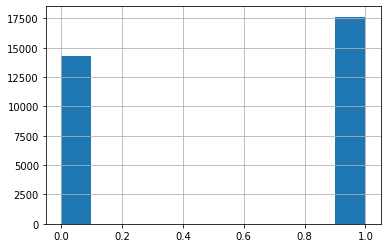

In [30]:
#check how many positives and negatives there are in the dataset
data[data.columns[-1]].hist()

array([[<AxesSubplot:title={'center':'TP9_alpha_to_theta'}>,
        <AxesSubplot:title={'center':'TP9_alpha_to_beta'}>,
        <AxesSubplot:title={'center':'TP9_theta_to_beta'}>,
        <AxesSubplot:title={'center':'AF7_alpha_to_theta'}>],
       [<AxesSubplot:title={'center':'AF7_alpha_to_beta'}>,
        <AxesSubplot:title={'center':'AF7_theta_to_beta'}>,
        <AxesSubplot:title={'center':'AF8_alpha_to_theta'}>,
        <AxesSubplot:title={'center':'AF8_alpha_to_beta'}>],
       [<AxesSubplot:title={'center':'AF8_theta_to_beta'}>,
        <AxesSubplot:title={'center':'TP10_alpha_to_theta'}>,
        <AxesSubplot:title={'center':'TP10_alpha_to_beta'}>,
        <AxesSubplot:title={'center':'TP10_theta_to_beta'}>],
       [<AxesSubplot:title={'center':'drowsy'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

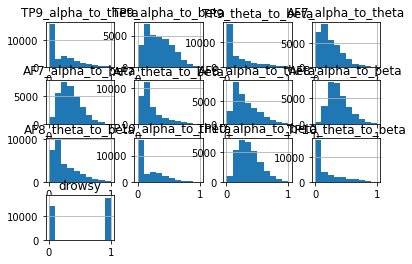

In [31]:
data.hist()

In [32]:
n_classes = len(np.unique(data[data.columns[-1]]))
n_features = len(data.columns) - 1
print("Number of classes: ", n_classes)
print("Number of features: ", n_features)

Number of classes:  2
Number of features:  12


In [33]:
#split up data into training and testing
train, test = train_test_split(data, test_size=0.4, shuffle=True, random_state=27)
x_train = train.iloc[:,:-1] # all rows, columns up until last(target)
y_train = train.iloc[:, -1] # all rows, only target column
x_test_full = test.iloc[:, :-1]
y_test_full = test.iloc[:, -1]

In [34]:
#hidden layers in a pyramid fashion, less neurons at the outer layers
#regularization: kernel_regularizer=keras.regularizers.l2(0.01)
#hidden layer activation: relu(o), sigmoid, tanh
#output layer activation: linear, sigmoid, softmax(o)
model1 = keras.Sequential([
    keras.layers.Dense(n_features + 1, input_dim=n_features),  # input layer (1)
    keras.layers.Dense(int(n_features / 2) + 1, activation='relu'),  # hidden layer (2)
    keras.layers.Dropout(0.2),
    #keras.layers.Dense(int(n_features / 4) + 1, activation='relu'), # hidden layer (3)
    #keras.layers.Dropout(0.2),
    #keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)), # hidden layer (4)
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid') # output layer (5)
])

model1.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [35]:
earlystopping = keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                              mode ="min", patience = 5,
                                              restore_best_weights = True)

partition = int(test.shape[0]/2)
print(partition)
x_val = x_test_full[:partition]
y_val = y_test_full[:partition]

x_test = x_test_full[partition:]
y_test = y_test_full[partition:]

model1.fit(x_train, y_train, 
          epochs=100, 
          batch_size=32,
          validation_data = (x_val, y_val),
          callbacks = [earlystopping])

6390
Train on 19170 samples, validate on 6390 samples
Epoch 1/100
19170/19170 [==============================] - 1s 59us/sample - loss: 0.5726 - acc: 0.7047 - val_loss: 0.4772 - val_acc: 0.7698
Epoch 2/100
19170/19170 [==============================] - 1s 48us/sample - loss: 0.4771 - acc: 0.7678 - val_loss: 0.4474 - val_acc: 0.7790
Epoch 3/100
19170/19170 [==============================] - 1s 49us/sample - loss: 0.4560 - acc: 0.7764 - val_loss: 0.4326 - val_acc: 0.7829
Epoch 4/100
19170/19170 [==============================] - 1s 47us/sample - loss: 0.4437 - acc: 0.7797 - val_loss: 0.4229 - val_acc: 0.7853
Epoch 5/100
19170/19170 [==============================] - 1s 49us/sample - loss: 0.4366 - acc: 0.7852 - val_loss: 0.4168 - val_acc: 0.7903
Epoch 6/100
19170/19170 [==============================] - 1s 49us/sample - loss: 0.4296 - acc: 0.7906 - val_loss: 0.4121 - val_acc: 0.7923
Epoch 7/100
19170/19170 [==============================] - 1s 49us/sample - loss: 0.4259 - acc: 0.7917 - v

In [36]:
#model1.fit(x_train, y_train, epochs=64, batch_size=32)

In [37]:
test_loss, test_acc = model1.evaluate(x_test, y_test, verbose=1)
print("Test accuracy: ", test_acc)

6391/6391 [==============================] - 0s 20us/sample - loss: 0.3626 - acc: 0.8363
Test accuracy:  0.8363323


In [38]:
#TESTING
y_pred = model1.predict(x_test)
y_pred = (y_pred > 0.5)

print(confusion_matrix(y_test, y_pred))
print(f1_score(y_test, y_pred, average=None))
print("Total accuracy: ", f1_score(y_test, y_pred, average='weighted'))

[[2164  645]
 [ 401 3181]]
[0.80535914 0.8588013 ]
Total accuracy:  0.8353121665723426


# Testing new data

In [287]:
#TESTING (FULL AWAKE) VALUES
#new_data = pd.read_csv("../MuseData/collected/testing/Ali_full_awake_30s_mid_tab_ratios.csv")
new_data = pd.read_csv("../MuseData/Ali_full_awake_2min_power_3ratios.csv")
new_data.head(10)

,timestamps,TP9_alpha_to_theta,TP9_alpha_to_beta,TP9_theta_to_beta,AF7_alpha_to_theta,AF7_alpha_to_beta,AF7_theta_to_beta,AF8_alpha_to_theta,AF8_alpha_to_beta,AF8_theta_to_beta,TP10_alpha_to_theta,TP10_alpha_to_beta,TP10_theta_to_beta
0,0.000000,0.165053,18.482805,111.981340,0.159045,9.017529,56.698002,0.136359,7.972278,58.465240,0.162784,19.140866,117.584712
1,0.390625,0.161829,18.730496,115.742452,0.154892,8.579934,55.392833,0.133546,7.244259,54.245392,0.157764,18.258537,115.733521
2,0.781250,0.118177,15.909688,134.625463,0.139887,8.731147,62.415551,0.145116,7.521488,51.830688,0.131099,16.172888,123.363939
3,1.171875,0.121036,24.961822,206.234427,0.152572,9.303534,60.977939,0.145062,7.303669,50.348754,0.131490,24.803012,188.630317
4,1.562500,0.122525,26.798663,218.719976,0.154341,8.202602,53.146111,0.154366,7.184240,46.540235,0.136364,29.149050,213.758928
5,1.953125,0.122364,26.323663,215.125650,0.152572,8.348317,54.717321,0.151184,7.309948,48.351345,0.135802,30.406455,223.902198
6,2.343750,0.117946,29.776455,252.459056,0.160719,9.747485,60.649270,0.146919,7.344021,49.986942,0.126815,28.826352,227.309739
7,2.734375,0.379276,27.356292,72.127619,0.190330,10.557464,55.469246,0.220485,8.484031,38.478940,0.398659,24.882732,62.416138
8,3.125000,0.151253,28.178765,186.302768,0.200817,10.309662,51.338615,0.181339,6.546266,36.099585,0.142974,24.672829,172.568591
9,3.515625,0.152488,23.720243,155.554349,0.233594,5.868330,25.121920,0.263484,5.407634,20.523561,0.144154,26.767651,185.688462


In [288]:
rand_start = random.randint(0, new_data.shape[0] - 78 - 1)
print(rand_start)
new_data = new_data.iloc[rand_start:rand_start + 78, :]
new_data.head(10)

5


,timestamps,TP9_alpha_to_theta,TP9_alpha_to_beta,TP9_theta_to_beta,AF7_alpha_to_theta,AF7_alpha_to_beta,AF7_theta_to_beta,AF8_alpha_to_theta,AF8_alpha_to_beta,AF8_theta_to_beta,TP10_alpha_to_theta,TP10_alpha_to_beta,TP10_theta_to_beta
5,1.953125,0.122364,26.323663,215.125650,0.152572,8.348317,54.717321,0.151184,7.309948,48.351345,0.135802,30.406455,223.902198
6,2.343750,0.117946,29.776455,252.459056,0.160719,9.747485,60.649270,0.146919,7.344021,49.986942,0.126815,28.826352,227.309739
7,2.734375,0.379276,27.356292,72.127619,0.190330,10.557464,55.469246,0.220485,8.484031,38.478940,0.398659,24.882732,62.416138
8,3.125000,0.151253,28.178765,186.302768,0.200817,10.309662,51.338615,0.181339,6.546266,36.099585,0.142974,24.672829,172.568591
9,3.515625,0.152488,23.720243,155.554349,0.233594,5.868330,25.121920,0.263484,5.407634,20.523561,0.144154,26.767651,185.688462
10,3.906250,0.147180,24.659965,167.550112,0.389354,4.197802,10.781462,0.284109,4.057480,14.281442,0.133631,27.649836,206.912197
11,4.296875,0.164709,15.550246,94.410233,0.338296,5.038910,14.894972,0.267839,4.013517,14.984792,0.148991,17.785136,119.370223
12,4.687500,0.149908,17.261042,115.144207,0.346899,4.496788,12.962828,0.341881,3.708496,10.847343,0.135687,21.248641,156.600897
13,5.078125,0.148587,17.876342,120.309224,0.399925,4.421143,11.054940,0.361106,2.775980,7.687443,0.135615,21.912866,161.582000
14,5.468750,0.156700,19.138729,122.136209,0.343959,4.737570,13.773642,0.363587,4.388956,12.071256,0.149006,26.421418,177.318236


Time to predict:  0.005156040191650391
[[51 23]
 [ 0  0]]
[0.816 0.   ]
Total accuracy:  0.8160000000000001


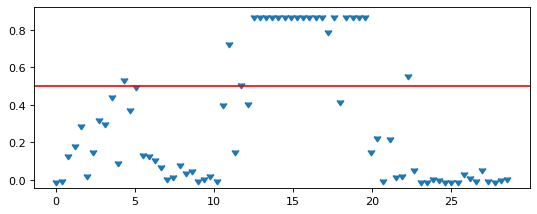

In [289]:
new_prediction_output(model1, new_data, False)

In [290]:
#TESTING (LESS AWAKE) VALUES
#new_data = pd.read_csv("../MuseData/collected/testing/Ali_less_awake_30s_mid_tab_ratios.csv")
new_data = pd.read_csv("../MuseData/Ali_less_awake_5min_power_3ratios.csv")
new_data.head(10)

,timestamps,TP9_alpha_to_theta,TP9_alpha_to_beta,TP9_theta_to_beta,AF7_alpha_to_theta,AF7_alpha_to_beta,AF7_theta_to_beta,AF8_alpha_to_theta,AF8_alpha_to_beta,AF8_theta_to_beta,TP10_alpha_to_theta,TP10_alpha_to_beta,TP10_theta_to_beta
0,0.000000,0.158626,12.585895,79.343023,0.123252,3.319840,26.935431,0.223840,6.658052,29.744707,0.147982,11.474701,77.541158
1,0.390625,0.218613,11.884330,54.362409,0.187807,4.576153,24.366284,0.262949,6.933687,26.368939,0.181642,10.175502,56.019618
2,0.781250,0.174894,8.059944,46.084717,0.274345,3.294939,12.010198,0.299016,5.818263,19.458041,0.144724,9.123429,63.040009
3,1.171875,0.109801,13.874092,126.356163,0.199500,4.480347,22.457903,0.293866,5.904517,20.092529,0.088190,13.332681,151.180650
4,1.562500,0.128448,12.018419,93.566288,0.199443,4.036385,20.238268,0.316678,5.585753,17.638601,0.096867,11.092748,114.515817
5,1.953125,0.134597,11.195285,83.176644,0.195400,3.862577,19.767534,0.254852,5.086919,19.960278,0.105260,10.827169,102.861523
6,2.343750,0.137955,10.862834,78.741820,0.198169,3.873109,19.544489,0.271314,4.441700,16.371095,0.118463,10.450719,88.219596
7,2.734375,0.120119,7.910059,65.851972,0.246919,4.337111,17.564944,0.324153,4.361370,13.454656,0.102133,7.536561,73.791841
8,3.125000,0.137808,9.644634,69.986009,0.243378,4.733413,19.448828,0.349577,4.742047,13.565105,0.122675,9.683093,78.932946
9,3.515625,0.127470,8.710929,68.336927,0.254704,4.901908,19.245539,0.304806,4.762338,15.624164,0.119668,9.483225,79.245813


In [291]:
rand_start = random.randint(0, new_data.shape[0] - 78 - 1)
print(rand_start)
new_data = new_data.iloc[rand_start:rand_start + 78, :]
new_data.head(10)

160


,timestamps,TP9_alpha_to_theta,TP9_alpha_to_beta,TP9_theta_to_beta,AF7_alpha_to_theta,AF7_alpha_to_beta,AF7_theta_to_beta,AF8_alpha_to_theta,AF8_alpha_to_beta,AF8_theta_to_beta,TP10_alpha_to_theta,TP10_alpha_to_beta,TP10_theta_to_beta
160,62.500000,0.067922,8.440395,124.266889,0.150639,3.543485,23.522966,0.131076,2.818431,21.502338,0.063691,7.295337,114.543181
161,62.890625,0.067176,8.292546,123.444893,0.136709,3.289037,24.058649,0.144045,3.079360,21.377824,0.062903,7.082215,112.590256
162,63.281250,0.052903,8.497414,160.623699,0.142512,3.417361,23.979519,0.117839,3.068963,26.043736,0.049621,7.399712,149.124179
163,63.671875,0.057896,8.043057,138.922591,0.234731,3.457885,14.731288,0.180086,4.155331,23.074211,0.054722,7.118685,130.087461
164,64.062500,0.061667,8.309727,134.752563,0.261313,3.890339,14.887679,0.126504,4.363783,34.495248,0.055698,7.488574,134.449555
165,64.453125,0.064793,6.706961,103.513517,0.390491,3.750037,9.603390,0.196664,4.420920,22.479536,0.063237,6.689081,105.778696
166,64.843750,0.066409,7.700578,115.957016,0.379586,3.911021,10.303392,0.191428,5.014559,26.195572,0.064247,7.302636,113.664418
167,65.234375,0.061424,5.853410,95.295470,0.323245,4.025555,12.453555,0.181152,5.163886,28.505786,0.074303,6.213049,83.617870
168,65.625000,0.068652,8.053395,117.308070,0.258970,4.944963,19.094739,0.175033,5.697768,32.552600,0.073783,7.728372,104.744052
169,66.015625,0.073862,12.318075,166.771605,0.213247,4.949176,23.208628,0.190089,6.675857,35.119583,0.074937,11.517547,153.697235


Time to predict:  0.005084037780761719
[[46 31]
 [ 0  0]]
[0.74796748 0.        ]
Total accuracy:  0.7479674796747967


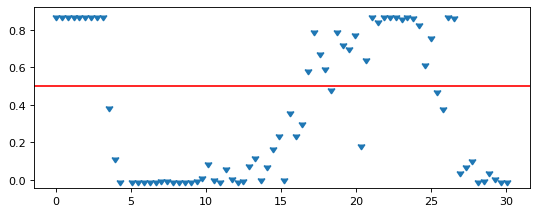

In [292]:
new_prediction_output(model1, new_data, False)

In [296]:
#TESTING (DROWSY) VALUES
#new_data = pd.read_csv("../MuseData/collected/testing/Ali_drowsy_30s_mid_tab_ratios.csv")
new_data = pd.read_csv("../MuseData/Ali_drowsy_5min_power_3ratios.csv")
new_data.head(10)

,timestamps,TP9_alpha_to_theta,TP9_alpha_to_beta,TP9_theta_to_beta,AF7_alpha_to_theta,AF7_alpha_to_beta,AF7_theta_to_beta,AF8_alpha_to_theta,AF8_alpha_to_beta,AF8_theta_to_beta,TP10_alpha_to_theta,TP10_alpha_to_beta,TP10_theta_to_beta
0,0.000000,0.086606,8.505008,98.203156,0.187474,1.456433,7.768725,0.138756,1.959830,14.124246,0.078155,7.595378,97.182998
1,0.390625,0.085640,7.965850,93.015088,0.220069,1.535399,6.976911,0.197540,2.456021,12.433011,0.079002,7.134720,90.310573
2,0.781250,0.123306,7.106320,57.631612,0.461755,2.000413,4.332196,0.158782,2.067823,13.023032,0.112051,7.707600,68.786381
3,1.171875,0.093424,7.747101,82.923764,0.370776,2.004240,5.405522,0.182728,2.099344,11.488888,0.083391,7.812531,93.685335
4,1.562500,0.093498,7.714956,82.514323,0.447336,2.239269,5.005787,0.234527,2.796302,11.923174,0.086841,8.410625,96.851038
5,1.953125,0.074497,6.147838,82.524816,0.377218,2.087970,5.535180,0.219743,2.329554,10.601245,0.062834,6.058051,96.413399
6,2.343750,0.087896,6.268845,71.321265,0.411308,2.175303,5.288746,0.246074,2.500478,10.161505,0.082574,6.206028,75.157458
7,2.734375,0.073030,7.151763,97.928478,0.397423,2.201344,5.539042,0.198225,2.185789,11.026788,0.061565,6.411448,104.140641
8,3.125000,0.077253,6.524558,84.457514,0.370445,1.962266,5.297053,0.199082,2.039129,10.242664,0.060282,5.246767,87.036739
9,3.515625,0.097847,6.022920,61.554451,0.300051,1.824309,6.079993,0.168996,2.030589,12.015591,0.076235,4.362584,57.225343


In [297]:
rand_start = random.randint(0, new_data.shape[0] - 78 - 1)
print(rand_start)
new_data = new_data.iloc[rand_start:rand_start + 78, :]
new_data.head(10)

301


,timestamps,TP9_alpha_to_theta,TP9_alpha_to_beta,TP9_theta_to_beta,AF7_alpha_to_theta,AF7_alpha_to_beta,AF7_theta_to_beta,AF8_alpha_to_theta,AF8_alpha_to_beta,AF8_theta_to_beta,TP10_alpha_to_theta,TP10_alpha_to_beta,TP10_theta_to_beta
301,117.578125,0.067305,4.196237,62.346886,0.471608,1.264714,2.681708,0.449944,2.052998,4.562787,0.071048,3.995723,56.239656
302,117.968750,0.080371,4.354018,54.173732,0.426713,1.275515,2.989165,0.532842,1.982794,3.721165,0.077892,3.595722,46.163109
303,118.359375,0.071959,4.340570,60.319630,0.312474,1.007688,3.224869,0.625667,1.967686,3.144941,0.077054,3.880534,50.361109
304,118.750000,0.069928,4.311549,61.657072,0.314055,0.982830,3.129488,0.603012,1.986097,3.293630,0.076798,3.764185,49.014384
305,119.140625,0.071182,4.293286,60.313967,0.332437,1.154981,3.474288,0.499598,1.901521,3.806100,0.074440,3.677654,49.404353
306,119.531250,0.084659,3.184902,37.620140,0.296315,0.897523,3.028954,0.402707,1.594502,3.959460,0.076354,2.382035,31.197361
307,119.921875,0.082891,3.629549,43.787028,0.266783,0.739704,2.772679,0.395970,1.584298,4.001058,0.079382,2.984264,37.593870
308,120.312500,0.070862,4.246974,59.932683,0.258471,0.857314,3.316869,0.328186,1.746204,5.320775,0.066255,3.785408,57.133732
309,120.703125,0.131693,3.761158,28.559982,0.299997,0.936147,3.120523,0.418052,1.743702,4.171023,0.139931,3.914740,27.976220
310,121.093750,0.125279,3.200755,25.548916,0.306148,0.953449,3.114340,0.483706,2.016225,4.168282,0.143628,3.284391,22.867321


Time to predict:  0.004303693771362305
[[ 0  0]
 [54 22]]
[0.         0.44897959]
Total accuracy:  0.4489795918367347


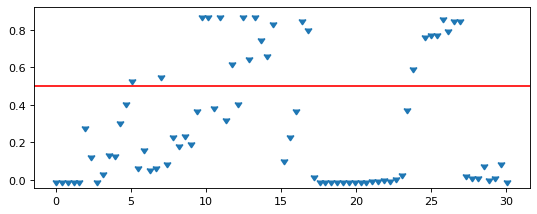

In [298]:
new_prediction_output(model1, new_data, True)

# Online Data

In [40]:
on_data = pd.read_csv("ddds_data/online/Online_power_f1-7_m1-7.csv")
on_data.head(10)

,time,HEOL,HEOR,FP1,FP2,VEOU,VEOL,F7,F3,FZ,...,T6,A2,O1,OZ,O2,FT9,FT10,PO1,PO2,drowsy
0,0,2.057207,0.270608,5.564671,NaN,5.397345,6.279081,8.347633,6.260097,6.946177,...,6.113396,3.427360,NaN,6.516418,6.260097,10.792013,0.63596,14.332133,6.260097,0
1,4,1.069318,1.000000,1.995987,NaN,2.005905,6.279081,1.954402,6.260097,2.067475,...,6.113396,1.045627,NaN,2.588555,6.260097,0.415328,0.63596,2.944453,6.260097,0
2,8,0.781610,1.057375,2.230398,0.671261,2.538961,6.279081,3.582768,6.260097,1.490852,...,6.113396,0.883249,0.844458,3.678384,6.260097,1.600655,0.63596,4.486340,6.260097,0
3,12,1.029504,1.167187,1.592974,1.014722,2.385655,6.279081,2.937494,6.260097,2.240476,...,6.113396,1.007121,1.009158,2.970995,6.260097,0.913129,0.63596,3.377619,6.260097,0
4,16,0.806222,2.680043,3.968202,6.260097,2.525516,6.279081,3.250421,6.260097,1.779741,...,6.113396,2.411728,2.235222,3.962315,6.260097,2.511730,0.63596,5.534334,6.260097,0
5,20,1.101267,0.923014,2.503400,6.260097,1.592368,6.279081,1.096549,6.260097,1.394355,...,6.113396,2.066296,1.793097,1.906889,6.260097,1.677505,0.63596,2.462544,6.260097,0
6,24,1.324937,1.028199,1.675918,6.260097,2.010825,6.279081,3.565451,6.260097,2.056296,...,6.113396,1.914223,3.088796,2.487217,6.260097,2.279378,0.63596,2.459002,6.260097,0
7,28,0.909504,0.893794,1.176636,6.260097,1.212359,6.279081,3.198073,6.260097,1.301796,...,6.113396,0.958917,3.642419,1.342567,6.260097,1.307847,0.63596,1.772131,6.260097,0
8,32,1.400576,0.276718,1.048151,6.260097,1.235531,6.279081,1.642246,6.260097,1.036500,...,6.113396,0.763651,6.260097,1.959409,6.260097,1.638884,0.63596,1.880299,6.260097,0
9,36,0.704878,0.276718,1.401058,6.260097,1.812097,6.279081,2.131769,6.260097,1.524662,...,6.113396,1.033130,6.260097,2.443189,6.260097,2.694694,0.63596,2.554038,6.260097,0


In [41]:
on_data = preprocess_online(on_data, True)
on_data.head(10)

,HEOL,FP1,VEOU,F7,FZ,F8,FC3,FC4,FT8,T3,...,CP4,A1,T5,P3,P4,A2,OZ,FT9,PO1,drowsy
1,0.238617,0.597942,0.449865,0.420614,0.445550,0.180138,0.342765,0.258790,0.999662,0.470165,...,0.533549,0.501360,0.792766,0.384707,0.243605,0.305867,0.555423,0.084087,0.583243,0
2,0.173692,0.668800,0.571836,0.776258,0.320572,0.108799,0.318072,0.165071,0.999662,0.638516,...,0.788809,0.683182,0.792766,0.444828,0.261660,0.257770,0.790433,0.335219,0.890896,0
3,0.229632,0.476119,0.536758,0.635326,0.483046,0.210886,0.342346,0.213278,0.999662,0.504189,...,0.714525,0.516529,0.792766,0.320132,0.240494,0.294461,0.637892,0.189555,0.669673,0
5,0.245827,0.751324,0.355242,0.233254,0.299657,0.154909,0.356636,0.137085,0.999662,0.250949,...,0.385808,0.248111,0.792766,0.150440,0.161727,0.608194,0.408429,0.351501,0.487088,0
6,0.296301,0.501192,0.450991,0.772475,0.443127,0.242971,0.328875,0.284316,0.999662,0.493377,...,0.576580,0.506050,0.792766,0.457618,0.354771,0.563149,0.533570,0.479018,0.486381,0
7,0.202553,0.350268,0.268290,0.692238,0.279596,0.158117,0.184319,0.116045,0.999662,0.249360,...,0.237385,0.243866,0.792766,0.178724,0.138256,0.280183,0.286739,0.273182,0.349329,0
8,0.313370,0.311430,0.273592,0.352437,0.222096,0.124387,0.435552,0.164926,0.999662,0.266267,...,0.428539,0.242513,0.792766,0.149503,0.146426,0.222344,0.419754,0.343318,0.370912,0
9,0.156376,0.418106,0.405519,0.459352,0.327900,0.139825,0.396554,0.158265,0.999662,0.476108,...,0.466804,0.386853,0.792766,0.233560,0.162439,0.302165,0.524076,0.567010,0.505344,0
10,0.169741,0.420697,0.299709,0.202762,0.215066,0.098915,0.372582,0.139323,0.999662,0.323651,...,0.417388,0.264887,0.792766,0.229126,0.164017,0.291133,0.411153,0.353662,0.463589,0
11,0.074865,0.379467,0.191608,0.169056,0.177432,0.088488,0.135057,0.101492,0.999662,0.195637,...,0.176043,0.208706,0.792766,0.139890,0.130580,0.257807,0.337984,0.218816,0.390421,0


<AxesSubplot:>

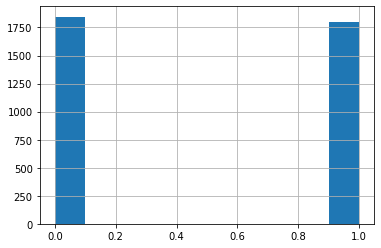

In [42]:
#check how many positives and negatives there are in the dataset
on_data[on_data.columns[-1]].hist()

In [43]:
on_n_classes = len(np.unique(on_data[on_data.columns[-1]]))
on_n_features = len(on_data.columns) - 1
print("Number of classes: ", on_n_classes)
print("Number of features: ", on_n_features)

Number of classes:  2
Number of features:  23


In [44]:
#split up data into training and testing
on_train, on_test = train_test_split(on_data, test_size=0.4, shuffle=True, random_state=27)
on_x_train = on_train.iloc[:,:-1] # all rows, columns up until last(target)
on_y_train = on_train.iloc[:, -1] # all rows, only target column
on_x_test_full = on_test.iloc[:, :-1]
on_y_test_full = on_test.iloc[:, -1]

In [50]:
#hidden layers in a pyramid fashion, less neurons at the outer layers
#hidden layer activation: relu(o), sigmoid, tanh
#output layer activation: linear, sigmoid, softmax(o)
#dropout layer: keras.layers.Dropout(0.2),
#regularization: kernel_regularizer=keras.regularizers.l2(0.01)

model2 = keras.Sequential([
    keras.layers.Dense(on_n_features + 1, input_dim=on_n_features),  # input layer (1)
    keras.layers.Dense(int(on_n_features / 2) + 1, 
                       activation='relu'),
                       #kernel_regularizer=keras.regularizers.l2(0.001)),  # hidden layer (2)
    keras.layers.Dropout(0.2),
    keras.layers.Dense(int(on_n_features / 4) + 1, activation='relu'), # hidden layer (3)
    keras.layers.Dropout(0.2),
    #keras.layers.Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)), # hidden layer (4)
    #keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid') # output layer (5)
])

model2.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [46]:
earlystopping = keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                              mode ="min", patience = 5,
                                              restore_best_weights = True)

#split "testing" data into validation and final testing
on_partition = int(on_test.shape[0]/2)
print(partition)
on_x_val = on_x_test_full[:on_partition]
on_y_val = on_y_test_full[:on_partition]

on_x_test = on_x_test_full[on_partition:]
on_y_test = on_y_test_full[on_partition:]

model2.fit(on_x_train, on_y_train, 
          epochs=100, 
          batch_size=32,
          validation_data = (on_x_val, on_y_val),
          callbacks = [earlystopping])

6390
Train on 2189 samples, validate on 730 samples
Epoch 1/100
2189/2189 [==============================] - 0s 155us/sample - loss: 0.6639 - acc: 0.6103 - val_loss: 0.6193 - val_acc: 0.6877
Epoch 2/100
2189/2189 [==============================] - 0s 55us/sample - loss: 0.5868 - acc: 0.7309 - val_loss: 0.5453 - val_acc: 0.7329
Epoch 3/100
2189/2189 [==============================] - 0s 51us/sample - loss: 0.5265 - acc: 0.7414 - val_loss: 0.4851 - val_acc: 0.7548
Epoch 4/100
2189/2189 [==============================] - 0s 52us/sample - loss: 0.4800 - acc: 0.7638 - val_loss: 0.4372 - val_acc: 0.7808
Epoch 5/100
2189/2189 [==============================] - 0s 51us/sample - loss: 0.4361 - acc: 0.7972 - val_loss: 0.3988 - val_acc: 0.8274
Epoch 6/100
2189/2189 [==============================] - 0s 51us/sample - loss: 0.4089 - acc: 0.8278 - val_loss: 0.3678 - val_acc: 0.8507
Epoch 7/100
2189/2189 [==============================] - 0s 50us/sample - loss: 0.3743 - acc: 0.8451 - val_loss: 0.3361

In [47]:
#model2.fit(x_train, y_train, epochs=64, batch_size=32)

In [48]:
on_test_loss, on_test_acc = model2.evaluate(on_x_test, on_y_test, verbose=1)
print("Test accuracy: ", on_test_acc)

730/730 [==============================] - 0s 24us/sample - loss: 0.1575 - acc: 0.9466
Test accuracy:  0.94657534


In [49]:
on_y_pred = model2.predict(on_x_test)
on_y_pred = (on_y_pred > 0.5)

print(confusion_matrix(on_y_test, on_y_pred))
print(f1_score(on_y_test, on_y_pred, average=None))
print("Total accuracy: ", f1_score(on_y_test, on_y_pred, average='weighted'))

[[344  21]
 [ 18 347]]
[0.94635488 0.946794  ]
Total accuracy:  0.9465744401763213
